---
*   **author:** Marián Pukančík
*   **učo**: 506485
*   **title:** Brain MRI classification and segmentation
*   **subject:** PA026

---


# Imports and global model settings

In [1]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
!pip install medpy
!pip install torchshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.1 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214946 sha256=e3110163f6d9aec67f5a6e8b876895f263211d1caffb9f790120323a34fe267b
  Stored in directory: /root/.cache/pip/wheels/d4/32/c7/6380ab2edb8cca018d39a0f1d43250fd9791922c963117de46
Successfully built medpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import torchshow as ts
import torch
import torch.nn as nn

import medpy
import medpy.metric

import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
from torch.utils.data import Dataset

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

[GOOGLE COLABORATORY] For running the notebook via Google Colaboratory, you might need to slightly change the project path. It expects the project directory to be upluaded on your Google Drive.

In [3]:
# Mount your Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the path to project directory
PROJECT_PATH = '/content/drive/My Drive/PA026/'

# Add project path into the system path
sys.path.insert(0,PROJECT_PATH)

Mounted at /content/drive


[LOCAL MACHINE] If you want to run this on your local machine, run this cell instead of the one above. However, keep in mind that this project was developed in Google Colaboratory enviroment, so i cannot guarantee 100 percent functionalty elsewhere. With that beeing said, it was tested on different machine and run well, so it should work. 

In [ ]:
# for running on your local machine
#PROJECT_PATH = './'

In [4]:
from scripts import dataFunctions, augmentations, dataset, diceLoss, unet, evaluation

In [5]:
# define the test split
TEST_SPLIT = 0.20

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0003
NUM_EPOCHS = 60
BATCH_SIZE = 30


# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256

# define threshold to filter weak predictions
THRESHOLD = 0.5

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# Data paths

If you already have the 'mainClassSegData.csv' file then run the following cell as it is. If not, uncomment the first line of code in order to generate .csv file containing filepaths and labels for the main dataset.

<Axes: xlabel='label', ylabel='count'>

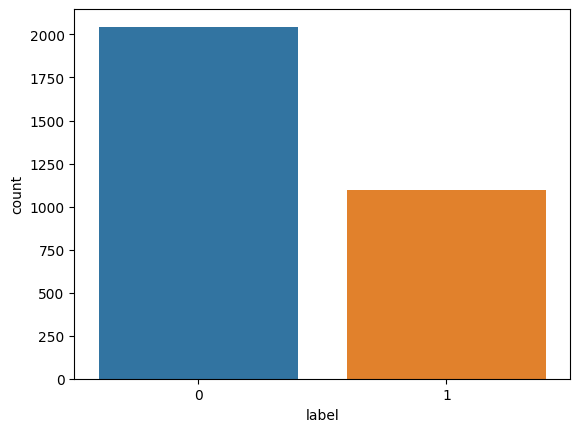

In [6]:
#dataFunctions.getMainDatasetPaths(PROJECT_PATH)
data = pd.read_csv(PROJECT_PATH+'data/mainWithoutTestData.csv')
sns.countplot(data=data, x='label')

To train the segmentation model, we will only use images containing the tumor

<ipython-input-7-e6909018a0bc>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tumorData = tumorData.append(row, ignore_index = True)


<Axes: xlabel='label', ylabel='count'>

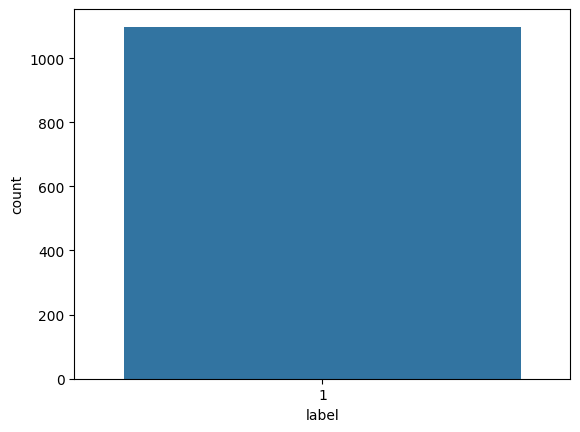

In [7]:
tumorData = pd.DataFrame()
data['label'] = data['label'].astype('int')


for index, row in data.iterrows():
    if(row['label'] == 1):
        tumorData = tumorData.append(row, ignore_index = True)

sns.countplot(data=tumorData, x='label')

# 5-fold cross validation

In [8]:
'''
@brief: Function returns DeepLabV3Plus model with pretrained encoder.'''
def getDeepLabModel():
    ENCODER = 'resnet101'
    ENCODER_WEIGHTS = 'imagenet'
    ACTIVATION = 'sigmoid' 

    # instantiate segmentation model with pretrained encoder
    model = smp.DeepLabV3Plus(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=1, 
        activation=ACTIVATION,
    )

    return model

'''
@brief: Function returns U-Net model'''
def getUnetModel():
    return unet.UNet(nClasses=1)

In [ ]:
# Split training data into the given number of folds
splits=KFold(n_splits=5, shuffle=True, random_state=42)

# image paths
imagePaths = sorted(list(tumorData['image']))
# ground truth label mask paths
maskPaths = sorted(list(tumorData['mask']))

# get train and validation augmentations
transformTrain = augmentations.getTrainAugmentations(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)
transformVal = augmentations.getTestAugmentations(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)

# create datasets for training and validation
# they are the same, just with different augmentations
# we will sample from them depending on the current fold
trainDS = dataset.SegmentationDataset(imagePaths, maskPaths, transformTrain)
valDS = dataset.SegmentationDataset(imagePaths, maskPaths, transformVal)

print(f'[INFO] Found {len(trainDS)} examples in the whole training set...')
print(f'[INFO] Starting 5-fold cross validation.')

results = pd.DataFrame(columns=['pixelAcc', 'dice', 'precision','recall','jaccard','f0_5','f2','hd','assd'])

# we will use soft approximation of Dice coef. as loss function
lossFunc = diceLoss.DiceLoss()

# Run cross-validation
for fold, (trainIdx, valIdx) in enumerate(splits.split(np.arange(len(imagePaths)))):

    # Random samplers for train/validation parts of current fold
    trainSampler = SubsetRandomSampler(trainIdx)
    valSampler = SubsetRandomSampler(valIdx)

    # Create data loaders for current train/validation fold
    # Loader feeds network with batches of data
    # Samples within each batch are randomly sampled without replacement
    trainLoader = DataLoader(trainDS,
        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,sampler=trainSampler)
    valLoader = DataLoader(valDS,
        batch_size=1, pin_memory=PIN_MEMORY,sampler=valSampler)

    # get new instance of the model, optimizer
    model = getUnetModel().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)

    trainSteps = len(trainIdx) // BATCH_SIZE
    valSteps = len(valIdx) 

    print("Training the network...")
    startTime = time.time()
    bestScore = 100.0

    # loop over epochs
    for epoch in tqdm(range(NUM_EPOCHS)):
        # set the model in training mode
        model.train()
        # initialize the total training and validation loss
        totalTrainLoss = 0
        totalValLoss = 0

        # loop over the training set
        for (i, (x, y)) in enumerate(trainLoader):
            
            (x,y) = (x.to(DEVICE), y.squeeze().type(torch.LongTensor).to(DEVICE))
            pred = model(x)                          # perform a forward pass
            loss = lossFunc(pred, y)
            
            opt.zero_grad()                         # zero out any previously accumulated gradients
            loss.backward()                         # perform backpropagation
            opt.step()                              # update model parameters
            
            totalTrainLoss += loss

        #first feature map channel of the last image from each batch
        with torch.no_grad():
            # set the model in evaluation mode
            model.eval()
            # loop over the validation set
            for (x, y) in valLoader:
                (x, y) = (x.to(DEVICE), y.squeeze().type(torch.LongTensor).to(DEVICE))
                pred = model(x)
                totalValLoss += lossFunc(pred, y)

        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgValLoss = totalValLoss / valSteps

        # save if best model so far with the respect to validation loss
        if(bestScore > avgValLoss):
            bestScore = avgValLoss
            print('Saving the model!!!')
            #torch.save(model.state_dict(), PROJECT_PATH+'savedModels/segmentation/DeepLabV3PLus'+str(fold+1)+'.pt')
            torch.save(model.state_dict(), PROJECT_PATH+'savedModels/segmentation/UNet'+str(fold+1)+'.pt')
            

        # print the model training and validation information
        print("EPOCH: {}/{}".format(epoch + 1, NUM_EPOCHS))
        print("Train loss: {:.8f}, Val loss: {:.8f}".format( avgTrainLoss, avgValLoss))

    endTime = time.time()
    print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

    print('[INFO] Loading the best model.')
    #model.load_state_dict(torch.load(PROJECT_PATH+'savedModels/segmentation/DeepLabV3PLus'+str(fold+1)+'.pt'))
    model.load_state_dict(torch.load(PROJECT_PATH+'savedModels/segmentation/UNet'+str(fold+1)+'.pt'))
    results = evaluation.evaluate(model, valLoader, len(valIdx), results, True)

foldNames = []
for i in range(5):
	foldNames.append('fold_'+str(i+1))
results.index = foldNames
results.to_csv(PROJECT_PATH+'results.csv')

print('[INFO] Results on idividual validation parts are saved in "results.csv" file.')
print('[INFO] The best model for each fold is saved in the "models" directory.')

[INFO] Found 1098 examples in the whole training set...
[INFO] Starting 5-fold cross validation.
Training the network...


  0%|          | 0/60 [00:00<?, ?it/s]

Saving the model!!!


  2%|▏         | 1/60 [00:52<51:25, 52.29s/it]

EPOCH: 1/60
Train loss: 0.86557084, Val loss: 0.90610635
Saving the model!!!


  3%|▎         | 2/60 [01:43<50:02, 51.77s/it]

EPOCH: 2/60
Train loss: 0.81579781, Val loss: 0.80727112
Saving the model!!!


  5%|▌         | 3/60 [02:34<48:52, 51.45s/it]

EPOCH: 3/60
Train loss: 0.78432673, Val loss: 0.77320153
Saving the model!!!


  7%|▋         | 4/60 [03:26<47:57, 51.38s/it]

EPOCH: 4/60
Train loss: 0.73529232, Val loss: 0.70493579
Saving the model!!!


  8%|▊         | 5/60 [04:17<47:00, 51.28s/it]

EPOCH: 5/60
Train loss: 0.68747371, Val loss: 0.69916284
Saving the model!!!


 10%|█         | 6/60 [05:08<46:05, 51.21s/it]

EPOCH: 6/60
Train loss: 0.63354951, Val loss: 0.65915209
Saving the model!!!


 12%|█▏        | 7/60 [05:59<45:11, 51.16s/it]

EPOCH: 7/60
Train loss: 0.56909496, Val loss: 0.60620385
Saving the model!!!


 13%|█▎        | 8/60 [06:50<44:16, 51.08s/it]

EPOCH: 8/60
Train loss: 0.51137221, Val loss: 0.55605382
Saving the model!!!


 15%|█▌        | 9/60 [07:41<43:23, 51.05s/it]

EPOCH: 9/60
Train loss: 0.45532778, Val loss: 0.50241965
Saving the model!!!


 17%|█▋        | 10/60 [08:32<42:32, 51.05s/it]

EPOCH: 10/60
Train loss: 0.41861397, Val loss: 0.46596539


 18%|█▊        | 11/60 [09:23<41:38, 50.99s/it]

EPOCH: 11/60
Train loss: 0.37835008, Val loss: 0.49504048
Saving the model!!!


 20%|██        | 12/60 [10:14<40:48, 51.01s/it]

EPOCH: 12/60
Train loss: 0.33942384, Val loss: 0.41515321
Saving the model!!!


 22%|██▏       | 13/60 [11:05<39:58, 51.03s/it]

EPOCH: 13/60
Train loss: 0.30710647, Val loss: 0.41222280


 23%|██▎       | 14/60 [11:55<39:03, 50.95s/it]

EPOCH: 14/60
Train loss: 0.27738708, Val loss: 0.43051225
Saving the model!!!


 25%|██▌       | 15/60 [12:47<38:14, 50.99s/it]

EPOCH: 15/60
Train loss: 0.26485357, Val loss: 0.34425142


 27%|██▋       | 16/60 [13:37<37:22, 50.95s/it]

EPOCH: 16/60
Train loss: 0.24821420, Val loss: 0.35309508
Saving the model!!!


 28%|██▊       | 17/60 [14:28<36:30, 50.95s/it]

EPOCH: 17/60
Train loss: 0.22499508, Val loss: 0.32628256


 30%|███       | 18/60 [15:19<35:37, 50.88s/it]

EPOCH: 18/60
Train loss: 0.23059094, Val loss: 0.34598562
Saving the model!!!


 32%|███▏      | 19/60 [16:10<34:49, 50.97s/it]

EPOCH: 19/60
Train loss: 0.23091270, Val loss: 0.29403675
Saving the model!!!


 33%|███▎      | 20/60 [17:01<34:00, 51.02s/it]

EPOCH: 20/60
Train loss: 0.19796139, Val loss: 0.29166043


 35%|███▌      | 21/60 [17:52<33:05, 50.91s/it]

EPOCH: 21/60
Train loss: 0.19375820, Val loss: 0.30882350


 37%|███▋      | 22/60 [18:43<32:13, 50.88s/it]

EPOCH: 22/60
Train loss: 0.18209928, Val loss: 0.30190602


 38%|███▊      | 23/60 [19:34<31:22, 50.89s/it]

EPOCH: 23/60
Train loss: 0.18416677, Val loss: 0.31006306
Saving the model!!!


 40%|████      | 24/60 [20:25<30:33, 50.93s/it]

EPOCH: 24/60
Train loss: 0.18196557, Val loss: 0.27359453
Saving the model!!!


 42%|████▏     | 25/60 [21:16<29:44, 50.99s/it]

EPOCH: 25/60
Train loss: 0.16645306, Val loss: 0.22997011
Saving the model!!!


 43%|████▎     | 26/60 [22:07<28:55, 51.06s/it]

EPOCH: 26/60
Train loss: 0.15702626, Val loss: 0.22442216
Saving the model!!!


 45%|████▌     | 27/60 [22:58<28:04, 51.04s/it]

EPOCH: 27/60
Train loss: 0.15258278, Val loss: 0.22305566


 47%|████▋     | 28/60 [23:49<27:11, 50.98s/it]

EPOCH: 28/60
Train loss: 0.15500306, Val loss: 0.27010262


 48%|████▊     | 29/60 [24:40<26:19, 50.95s/it]

EPOCH: 29/60
Train loss: 0.15898693, Val loss: 0.27420709


 50%|█████     | 30/60 [25:31<25:27, 50.91s/it]

EPOCH: 30/60
Train loss: 0.17487857, Val loss: 0.24298857


 52%|█████▏    | 31/60 [26:21<24:35, 50.88s/it]

EPOCH: 31/60
Train loss: 0.15400097, Val loss: 0.24354205
Saving the model!!!


 53%|█████▎    | 32/60 [27:13<23:47, 50.98s/it]

EPOCH: 32/60
Train loss: 0.14256005, Val loss: 0.21891606
Saving the model!!!


 55%|█████▌    | 33/60 [28:04<22:58, 51.04s/it]

EPOCH: 33/60
Train loss: 0.14492267, Val loss: 0.21104583
Saving the model!!!


 57%|█████▋    | 34/60 [28:55<22:08, 51.09s/it]

EPOCH: 34/60
Train loss: 0.13504301, Val loss: 0.20643093


 58%|█████▊    | 35/60 [29:46<21:15, 51.02s/it]

EPOCH: 35/60
Train loss: 0.13905509, Val loss: 0.24941345


 60%|██████    | 36/60 [30:37<20:22, 50.94s/it]

EPOCH: 36/60
Train loss: 0.13845107, Val loss: 0.22162333


 62%|██████▏   | 37/60 [31:27<19:30, 50.89s/it]

EPOCH: 37/60
Train loss: 0.13515420, Val loss: 0.23559226


 63%|██████▎   | 38/60 [32:18<18:37, 50.82s/it]

EPOCH: 38/60
Train loss: 0.13014330, Val loss: 0.21306224


 65%|██████▌   | 39/60 [33:09<17:47, 50.84s/it]

EPOCH: 39/60
Train loss: 0.12754788, Val loss: 0.25461620
Saving the model!!!


 67%|██████▋   | 40/60 [34:00<16:58, 50.93s/it]

EPOCH: 40/60
Train loss: 0.12857719, Val loss: 0.19075835
Saving the model!!!


 68%|██████▊   | 41/60 [34:51<16:09, 51.04s/it]

EPOCH: 41/60
Train loss: 0.12347053, Val loss: 0.18085875


 70%|███████   | 42/60 [35:42<15:18, 51.00s/it]

EPOCH: 42/60
Train loss: 0.12572844, Val loss: 0.19454862


 72%|███████▏  | 43/60 [36:33<14:26, 50.97s/it]

EPOCH: 43/60
Train loss: 0.13166371, Val loss: 0.20170771


 73%|███████▎  | 44/60 [37:24<13:34, 50.93s/it]

EPOCH: 44/60
Train loss: 0.13587268, Val loss: 0.21658787


 75%|███████▌  | 45/60 [38:15<12:43, 50.91s/it]

EPOCH: 45/60
Train loss: 0.12778522, Val loss: 0.20599848


 77%|███████▋  | 46/60 [39:06<11:52, 50.88s/it]

EPOCH: 46/60
Train loss: 0.12421763, Val loss: 0.24962042


 78%|███████▊  | 47/60 [39:57<11:01, 50.87s/it]

EPOCH: 47/60
Train loss: 0.12908106, Val loss: 0.19983673


 80%|████████  | 48/60 [40:47<10:10, 50.86s/it]

EPOCH: 48/60
Train loss: 0.12951420, Val loss: 0.23814912


 82%|████████▏ | 49/60 [41:38<09:19, 50.86s/it]

EPOCH: 49/60
Train loss: 0.12148199, Val loss: 0.19546460


 83%|████████▎ | 50/60 [42:29<08:28, 50.87s/it]

EPOCH: 50/60
Train loss: 0.12170138, Val loss: 0.19299184


 85%|████████▌ | 51/60 [43:20<07:37, 50.88s/it]

EPOCH: 51/60
Train loss: 0.11471774, Val loss: 0.18232435


 87%|████████▋ | 52/60 [44:11<06:47, 50.90s/it]

EPOCH: 52/60
Train loss: 0.11089908, Val loss: 0.19026467


 88%|████████▊ | 53/60 [45:02<05:56, 50.89s/it]

EPOCH: 53/60
Train loss: 0.10888399, Val loss: 0.18319295


 90%|█████████ | 54/60 [45:53<05:05, 50.89s/it]

EPOCH: 54/60
Train loss: 0.11008583, Val loss: 0.24267301
Saving the model!!!


 92%|█████████▏| 55/60 [46:44<04:14, 51.00s/it]

EPOCH: 55/60
Train loss: 0.10824318, Val loss: 0.17803799


 93%|█████████▎| 56/60 [47:35<03:23, 50.97s/it]

EPOCH: 56/60
Train loss: 0.11328534, Val loss: 0.22323878


 95%|█████████▌| 57/60 [48:26<02:32, 50.92s/it]

EPOCH: 57/60
Train loss: 0.11332362, Val loss: 0.23700649


 97%|█████████▋| 58/60 [49:17<01:41, 50.89s/it]

EPOCH: 58/60
Train loss: 0.15602036, Val loss: 0.21256784


 98%|█████████▊| 59/60 [50:07<00:50, 50.88s/it]

EPOCH: 59/60
Train loss: 0.12347570, Val loss: 0.18694565


100%|██████████| 60/60 [50:58<00:00, 50.98s/it]

EPOCH: 60/60
Train loss: 0.11289849, Val loss: 0.19703646
Total time taken to train the model: 3058.83s
[INFO] Loading the best model.


 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
 0.994568 0.828136     0.8477 0.845829 0.750103 0.830569 0.834332 13.511441 1.024857
Training the network...


  0%|          | 0/60 [00:00<?, ?it/s]

Saving the model!!!


  2%|▏         | 1/60 [00:51<50:16, 51.12s/it]

EPOCH: 1/60
Train loss: 0.88566148, Val loss: 0.93157393
Saving the model!!!


  3%|▎         | 2/60 [01:42<49:26, 51.15s/it]

EPOCH: 2/60
Train loss: 0.84302413, Val loss: 0.84486455
Saving the model!!!


  5%|▌         | 3/60 [02:33<48:36, 51.16s/it]

EPOCH: 3/60
Train loss: 0.81253225, Val loss: 0.83154476
Saving the model!!!


  7%|▋         | 4/60 [03:24<47:43, 51.14s/it]

EPOCH: 4/60
Train loss: 0.78066766, Val loss: 0.80448008
Saving the model!!!


  8%|▊         | 5/60 [04:15<46:52, 51.14s/it]

EPOCH: 5/60
Train loss: 0.73706490, Val loss: 0.80305612
Saving the model!!!


 10%|█         | 6/60 [05:06<46:01, 51.14s/it]

EPOCH: 6/60
Train loss: 0.69156981, Val loss: 0.71794367
Saving the model!!!


 12%|█▏        | 7/60 [05:57<45:07, 51.09s/it]

EPOCH: 7/60
Train loss: 0.64409298, Val loss: 0.69462758
Saving the model!!!


 13%|█▎        | 8/60 [06:48<44:14, 51.06s/it]

EPOCH: 8/60
Train loss: 0.58955777, Val loss: 0.65877622
Saving the model!!!


 15%|█▌        | 9/60 [07:39<43:21, 51.02s/it]

EPOCH: 9/60
Train loss: 0.52739018, Val loss: 0.63617557
Saving the model!!!


 17%|█▋        | 10/60 [08:30<42:30, 51.02s/it]

EPOCH: 10/60
Train loss: 0.48165867, Val loss: 0.54926264
Saving the model!!!


 18%|█▊        | 11/60 [09:21<41:42, 51.06s/it]

EPOCH: 11/60
Train loss: 0.41957113, Val loss: 0.52803469
Saving the model!!!


 20%|██        | 12/60 [10:12<40:50, 51.05s/it]

EPOCH: 12/60
Train loss: 0.38550073, Val loss: 0.51474082
Saving the model!!!


 22%|██▏       | 13/60 [11:03<39:59, 51.04s/it]

EPOCH: 13/60
Train loss: 0.33775175, Val loss: 0.45323586


 23%|██▎       | 14/60 [11:54<39:05, 50.98s/it]

EPOCH: 14/60
Train loss: 0.32254389, Val loss: 0.50902516
Saving the model!!!


 25%|██▌       | 15/60 [12:45<38:16, 51.02s/it]

EPOCH: 15/60
Train loss: 0.29261345, Val loss: 0.42808071


 27%|██▋       | 16/60 [13:36<37:21, 50.95s/it]

EPOCH: 16/60
Train loss: 0.26894671, Val loss: 0.44062427
Saving the model!!!


 28%|██▊       | 17/60 [14:27<36:31, 50.97s/it]

EPOCH: 17/60
Train loss: 0.25667760, Val loss: 0.38019291
Saving the model!!!


 30%|███       | 18/60 [15:18<35:40, 50.97s/it]

EPOCH: 18/60
Train loss: 0.24811991, Val loss: 0.37979329


 32%|███▏      | 19/60 [16:09<34:46, 50.88s/it]

EPOCH: 19/60
Train loss: 0.24227113, Val loss: 0.41445324
Saving the model!!!


 33%|███▎      | 20/60 [17:00<33:56, 50.92s/it]

EPOCH: 20/60
Train loss: 0.21841307, Val loss: 0.34633708
Saving the model!!!


 35%|███▌      | 21/60 [17:51<33:07, 50.96s/it]

EPOCH: 21/60
Train loss: 0.21838836, Val loss: 0.30294481


 37%|███▋      | 22/60 [18:42<32:15, 50.92s/it]

EPOCH: 22/60
Train loss: 0.19678241, Val loss: 0.36627191
Saving the model!!!


 38%|███▊      | 23/60 [19:33<31:26, 50.99s/it]

EPOCH: 23/60
Train loss: 0.19678657, Val loss: 0.29671869


 40%|████      | 24/60 [20:24<30:34, 50.96s/it]

EPOCH: 24/60
Train loss: 0.18927380, Val loss: 0.31138295


 42%|████▏     | 25/60 [21:15<29:40, 50.88s/it]

EPOCH: 25/60
Train loss: 0.17450231, Val loss: 0.30050945
Saving the model!!!


 43%|████▎     | 26/60 [22:06<28:51, 50.93s/it]

EPOCH: 26/60
Train loss: 0.17403822, Val loss: 0.27366647


 45%|████▌     | 27/60 [22:56<27:59, 50.88s/it]

EPOCH: 27/60
Train loss: 0.17937213, Val loss: 0.28976047
Saving the model!!!


 47%|████▋     | 28/60 [23:48<27:11, 50.98s/it]

EPOCH: 28/60
Train loss: 0.17799498, Val loss: 0.24764423


 48%|████▊     | 29/60 [24:38<26:19, 50.96s/it]

EPOCH: 29/60
Train loss: 0.17559750, Val loss: 0.28013009


 50%|█████     | 30/60 [25:29<25:28, 50.94s/it]

EPOCH: 30/60
Train loss: 0.19313945, Val loss: 0.32598355


 52%|█████▏    | 31/60 [26:20<24:35, 50.88s/it]

EPOCH: 31/60
Train loss: 0.18031064, Val loss: 0.32682517


 53%|█████▎    | 32/60 [27:11<23:42, 50.79s/it]

EPOCH: 32/60
Train loss: 0.16565466, Val loss: 0.27361247
Saving the model!!!


 55%|█████▌    | 33/60 [28:02<22:54, 50.89s/it]

EPOCH: 33/60
Train loss: 0.16255455, Val loss: 0.24600160
Saving the model!!!


 57%|█████▋    | 34/60 [28:53<22:06, 51.00s/it]

EPOCH: 34/60
Train loss: 0.15116294, Val loss: 0.22773659
Saving the model!!!


 58%|█████▊    | 35/60 [29:44<21:16, 51.06s/it]

EPOCH: 35/60
Train loss: 0.14309438, Val loss: 0.21298039


 60%|██████    | 36/60 [30:35<20:24, 51.01s/it]

EPOCH: 36/60
Train loss: 0.14298078, Val loss: 0.23984417
Saving the model!!!


 62%|██████▏   | 37/60 [31:26<19:34, 51.06s/it]

EPOCH: 37/60
Train loss: 0.13108939, Val loss: 0.20900013


 63%|██████▎   | 38/60 [32:17<18:41, 50.97s/it]

EPOCH: 38/60
Train loss: 0.13989435, Val loss: 0.21874563


 65%|██████▌   | 39/60 [33:08<17:48, 50.88s/it]

EPOCH: 39/60
Train loss: 0.13732098, Val loss: 0.21627736


 67%|██████▋   | 40/60 [33:58<16:56, 50.81s/it]

EPOCH: 40/60
Train loss: 0.13942729, Val loss: 0.23516200


 68%|██████▊   | 41/60 [34:49<16:04, 50.77s/it]

EPOCH: 41/60
Train loss: 0.13395928, Val loss: 0.22899279


 70%|███████   | 42/60 [35:40<15:13, 50.75s/it]

EPOCH: 42/60
Train loss: 0.12844823, Val loss: 0.25296488
Saving the model!!!


 72%|███████▏  | 43/60 [36:31<14:24, 50.83s/it]

EPOCH: 43/60
Train loss: 0.12943746, Val loss: 0.20407104


 73%|███████▎  | 44/60 [37:22<13:33, 50.82s/it]

EPOCH: 44/60
Train loss: 0.12217998, Val loss: 0.21893604


 75%|███████▌  | 45/60 [38:12<12:42, 50.81s/it]

EPOCH: 45/60
Train loss: 0.12353747, Val loss: 0.21059796


 77%|███████▋  | 46/60 [39:03<11:51, 50.79s/it]

EPOCH: 46/60
Train loss: 0.14308079, Val loss: 0.22085229


 78%|███████▊  | 47/60 [39:54<10:59, 50.77s/it]

EPOCH: 47/60
Train loss: 0.13431495, Val loss: 0.21273385


 80%|████████  | 48/60 [40:45<10:09, 50.75s/it]

EPOCH: 48/60
Train loss: 0.12347569, Val loss: 0.23495513
Saving the model!!!


 82%|████████▏ | 49/60 [41:36<09:19, 50.85s/it]

EPOCH: 49/60
Train loss: 0.13141488, Val loss: 0.19491418


 83%|████████▎ | 50/60 [42:26<08:28, 50.84s/it]

EPOCH: 50/60
Train loss: 0.12354465, Val loss: 0.21256886


 85%|████████▌ | 51/60 [43:17<07:37, 50.82s/it]

EPOCH: 51/60
Train loss: 0.14048684, Val loss: 0.23426124


 87%|████████▋ | 52/60 [44:08<06:46, 50.82s/it]

EPOCH: 52/60
Train loss: 0.13585283, Val loss: 0.20411927


 88%|████████▊ | 53/60 [44:59<05:55, 50.81s/it]

EPOCH: 53/60
Train loss: 0.12368543, Val loss: 0.19805847


 90%|█████████ | 54/60 [45:50<05:04, 50.80s/it]

EPOCH: 54/60
Train loss: 0.11845654, Val loss: 0.20709573


 92%|█████████▏| 55/60 [46:40<04:13, 50.79s/it]

EPOCH: 55/60
Train loss: 0.12316997, Val loss: 0.20853016


 93%|█████████▎| 56/60 [47:31<03:23, 50.79s/it]

EPOCH: 56/60
Train loss: 0.12186742, Val loss: 0.20698448


 95%|█████████▌| 57/60 [48:22<02:32, 50.78s/it]

EPOCH: 57/60
Train loss: 0.12758203, Val loss: 0.22675540


 97%|█████████▋| 58/60 [49:13<01:41, 50.78s/it]

EPOCH: 58/60
Train loss: 0.11995870, Val loss: 0.20242928


 98%|█████████▊| 59/60 [50:03<00:50, 50.78s/it]

EPOCH: 59/60
Train loss: 0.12642610, Val loss: 0.20653884


100%|██████████| 60/60 [50:54<00:00, 50.91s/it]

EPOCH: 60/60
Train loss: 0.11734530, Val loss: 0.20689814
Total time taken to train the model: 3054.79s
[INFO] Loading the best model.


 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
  0.99365 0.815684   0.817561 0.853011 0.727023 0.811608 0.830388 15.786053 1.318366
Training the network...


  0%|          | 0/60 [00:00<?, ?it/s]

Saving the model!!!


  2%|▏         | 1/60 [00:51<50:12, 51.06s/it]

EPOCH: 1/60
Train loss: 0.88595289, Val loss: 0.90638572
Saving the model!!!


  3%|▎         | 2/60 [01:41<49:16, 50.97s/it]

EPOCH: 2/60
Train loss: 0.84169418, Val loss: 0.82964396


  5%|▌         | 3/60 [02:32<48:16, 50.82s/it]

EPOCH: 3/60
Train loss: 0.81455302, Val loss: 0.86809045
Saving the model!!!


  7%|▋         | 4/60 [03:23<47:30, 50.90s/it]

EPOCH: 4/60
Train loss: 0.77954102, Val loss: 0.82109177
Saving the model!!!


  8%|▊         | 5/60 [04:14<46:42, 50.95s/it]

EPOCH: 5/60
Train loss: 0.72365266, Val loss: 0.73731005
Saving the model!!!


 10%|█         | 6/60 [05:05<45:53, 50.99s/it]

EPOCH: 6/60
Train loss: 0.66564667, Val loss: 0.69378096
Saving the model!!!


 12%|█▏        | 7/60 [05:56<45:04, 51.02s/it]

EPOCH: 7/60
Train loss: 0.61159879, Val loss: 0.66193241
Saving the model!!!


 13%|█▎        | 8/60 [06:47<44:14, 51.04s/it]

EPOCH: 8/60
Train loss: 0.54338253, Val loss: 0.62532598
Saving the model!!!


 15%|█▌        | 9/60 [07:38<43:23, 51.05s/it]

EPOCH: 9/60
Train loss: 0.48197037, Val loss: 0.56064826
Saving the model!!!


 17%|█▋        | 10/60 [08:30<42:33, 51.06s/it]

EPOCH: 10/60
Train loss: 0.41654456, Val loss: 0.55749410


 18%|█▊        | 11/60 [09:20<41:37, 50.97s/it]

EPOCH: 11/60
Train loss: 0.37458032, Val loss: 0.56557178
Saving the model!!!


 20%|██        | 12/60 [10:11<40:48, 51.01s/it]

EPOCH: 12/60
Train loss: 0.35299522, Val loss: 0.46885455
Saving the model!!!


 22%|██▏       | 13/60 [11:03<39:59, 51.06s/it]

EPOCH: 13/60
Train loss: 0.31534255, Val loss: 0.41402957
Saving the model!!!


 23%|██▎       | 14/60 [11:54<39:12, 51.14s/it]

EPOCH: 14/60
Train loss: 0.28985664, Val loss: 0.35531902
Saving the model!!!


 25%|██▌       | 15/60 [12:45<38:22, 51.18s/it]

EPOCH: 15/60
Train loss: 0.26262137, Val loss: 0.34327957


 27%|██▋       | 16/60 [13:36<37:27, 51.08s/it]

EPOCH: 16/60
Train loss: 0.23365648, Val loss: 0.36994183


 28%|██▊       | 17/60 [14:27<36:33, 51.00s/it]

EPOCH: 17/60
Train loss: 0.22066820, Val loss: 0.34804946


 30%|███       | 18/60 [15:18<35:39, 50.95s/it]

EPOCH: 18/60
Train loss: 0.26681492, Val loss: 0.41590020


 32%|███▏      | 19/60 [16:08<34:46, 50.90s/it]

EPOCH: 19/60
Train loss: 0.21348079, Val loss: 0.35304904
Saving the model!!!


 33%|███▎      | 20/60 [17:00<33:58, 50.95s/it]

EPOCH: 20/60
Train loss: 0.20014618, Val loss: 0.30941373
Saving the model!!!


 35%|███▌      | 21/60 [17:51<33:10, 51.03s/it]

EPOCH: 21/60
Train loss: 0.18065937, Val loss: 0.30290428
Saving the model!!!


 37%|███▋      | 22/60 [18:42<32:21, 51.10s/it]

EPOCH: 22/60
Train loss: 0.17948073, Val loss: 0.28153664


 38%|███▊      | 23/60 [19:33<31:27, 51.01s/it]

EPOCH: 23/60
Train loss: 0.19242132, Val loss: 0.30354321


 40%|████      | 24/60 [20:24<30:34, 50.96s/it]

EPOCH: 24/60
Train loss: 0.18002395, Val loss: 0.30449301


 42%|████▏     | 25/60 [21:15<29:42, 50.94s/it]

EPOCH: 25/60
Train loss: 0.16392355, Val loss: 0.28220823
Saving the model!!!


 43%|████▎     | 26/60 [22:06<28:54, 51.01s/it]

EPOCH: 26/60
Train loss: 0.15867995, Val loss: 0.25429937


 45%|████▌     | 27/60 [22:57<28:02, 50.98s/it]

EPOCH: 27/60
Train loss: 0.15020718, Val loss: 0.26591808


 47%|████▋     | 28/60 [23:48<27:10, 50.96s/it]

EPOCH: 28/60
Train loss: 0.15323222, Val loss: 0.26350042


 48%|████▊     | 29/60 [24:38<26:18, 50.92s/it]

EPOCH: 29/60
Train loss: 0.15593305, Val loss: 0.27851561


 50%|█████     | 30/60 [25:29<25:26, 50.89s/it]

EPOCH: 30/60
Train loss: 0.14703166, Val loss: 0.26473272
Saving the model!!!


 52%|█████▏    | 31/60 [26:20<24:38, 50.98s/it]

EPOCH: 31/60
Train loss: 0.15066260, Val loss: 0.25324684


 53%|█████▎    | 32/60 [27:11<23:46, 50.94s/it]

EPOCH: 32/60
Train loss: 0.13822177, Val loss: 0.25967094
Saving the model!!!


 55%|█████▌    | 33/60 [28:02<22:56, 50.97s/it]

EPOCH: 33/60
Train loss: 0.13225508, Val loss: 0.22903629


 57%|█████▋    | 34/60 [28:53<22:03, 50.92s/it]

EPOCH: 34/60
Train loss: 0.13425112, Val loss: 0.24693844


 58%|█████▊    | 35/60 [29:44<21:11, 50.85s/it]

EPOCH: 35/60
Train loss: 0.13905790, Val loss: 0.24560297


 60%|██████    | 36/60 [30:35<20:19, 50.82s/it]

EPOCH: 36/60
Train loss: 0.14360988, Val loss: 0.23791267


 62%|██████▏   | 37/60 [31:25<19:28, 50.79s/it]

EPOCH: 37/60
Train loss: 0.13011491, Val loss: 0.23177689
Saving the model!!!


 63%|██████▎   | 38/60 [32:16<18:39, 50.91s/it]

EPOCH: 38/60
Train loss: 0.12619291, Val loss: 0.20842026


 65%|██████▌   | 39/60 [33:07<17:49, 50.91s/it]

EPOCH: 39/60
Train loss: 0.12622592, Val loss: 0.21632688


 67%|██████▋   | 40/60 [33:58<16:57, 50.90s/it]

EPOCH: 40/60
Train loss: 0.12324606, Val loss: 0.21347825


 68%|██████▊   | 41/60 [34:49<16:06, 50.85s/it]

EPOCH: 41/60
Train loss: 0.11953244, Val loss: 0.22877996


 70%|███████   | 42/60 [35:40<15:16, 50.89s/it]

EPOCH: 42/60
Train loss: 0.12160762, Val loss: 0.22874635
Saving the model!!!


 72%|███████▏  | 43/60 [36:31<14:25, 50.94s/it]

EPOCH: 43/60
Train loss: 0.11654899, Val loss: 0.20519169


 73%|███████▎  | 44/60 [37:22<13:34, 50.92s/it]

EPOCH: 44/60
Train loss: 0.11901713, Val loss: 0.23181513
Saving the model!!!


 75%|███████▌  | 45/60 [38:13<12:45, 51.04s/it]

EPOCH: 45/60
Train loss: 0.12000819, Val loss: 0.19871505


 77%|███████▋  | 46/60 [39:04<11:54, 51.01s/it]

EPOCH: 46/60
Train loss: 0.13240439, Val loss: 0.23439537


 78%|███████▊  | 47/60 [39:55<11:02, 50.95s/it]

EPOCH: 47/60
Train loss: 0.12914635, Val loss: 0.23296079


 80%|████████  | 48/60 [40:46<10:10, 50.89s/it]

EPOCH: 48/60
Train loss: 0.12845530, Val loss: 0.21729879


 82%|████████▏ | 49/60 [41:36<09:19, 50.85s/it]

EPOCH: 49/60
Train loss: 0.12475635, Val loss: 0.21761534


 83%|████████▎ | 50/60 [42:27<08:28, 50.81s/it]

EPOCH: 50/60
Train loss: 0.12301093, Val loss: 0.22839834


 85%|████████▌ | 51/60 [43:18<07:37, 50.80s/it]

EPOCH: 51/60
Train loss: 0.12038623, Val loss: 0.21793835


 87%|████████▋ | 52/60 [44:09<06:46, 50.79s/it]

EPOCH: 52/60
Train loss: 0.11981408, Val loss: 0.20238736


 88%|████████▊ | 53/60 [45:00<05:55, 50.79s/it]

EPOCH: 53/60
Train loss: 0.11604493, Val loss: 0.23149854


 90%|█████████ | 54/60 [45:50<05:04, 50.82s/it]

EPOCH: 54/60
Train loss: 0.10749337, Val loss: 0.21638891


 92%|█████████▏| 55/60 [46:41<04:14, 50.81s/it]

EPOCH: 55/60
Train loss: 0.11132465, Val loss: 0.20537606


 93%|█████████▎| 56/60 [47:32<03:23, 50.78s/it]

EPOCH: 56/60
Train loss: 0.11834873, Val loss: 0.24028821


 95%|█████████▌| 57/60 [48:23<02:32, 50.78s/it]

EPOCH: 57/60
Train loss: 0.11819937, Val loss: 0.19897380


 97%|█████████▋| 58/60 [49:13<01:41, 50.80s/it]

EPOCH: 58/60
Train loss: 0.11459891, Val loss: 0.21791433


 98%|█████████▊| 59/60 [50:04<00:50, 50.81s/it]

EPOCH: 59/60
Train loss: 0.11435363, Val loss: 0.20423087


100%|██████████| 60/60 [50:55<00:00, 50.93s/it]

EPOCH: 60/60
Train loss: 0.11493421, Val loss: 0.21645409
Total time taken to train the model: 3055.71s
[INFO] Loading the best model.


 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
 0.993445 0.811532    0.82585 0.836168 0.725876 0.811617 0.821829 13.162474 0.985419
Training the network...


  0%|          | 0/60 [00:00<?, ?it/s]

Saving the model!!!


  2%|▏         | 1/60 [00:51<50:13, 51.07s/it]

EPOCH: 1/60
Train loss: 0.91861975, Val loss: 0.90308750
Saving the model!!!


  3%|▎         | 2/60 [01:42<49:18, 51.00s/it]

EPOCH: 2/60
Train loss: 0.89507061, Val loss: 0.87849307
Saving the model!!!


  5%|▌         | 3/60 [02:33<48:27, 51.00s/it]

EPOCH: 3/60
Train loss: 0.88153905, Val loss: 0.85518181
Saving the model!!!


  7%|▋         | 4/60 [03:24<47:40, 51.08s/it]

EPOCH: 4/60
Train loss: 0.86600852, Val loss: 0.83946979
Saving the model!!!


  8%|▊         | 5/60 [04:15<46:50, 51.09s/it]

EPOCH: 5/60
Train loss: 0.85343701, Val loss: 0.80663043
Saving the model!!!


 10%|█         | 6/60 [05:06<45:57, 51.06s/it]

EPOCH: 6/60
Train loss: 0.83090997, Val loss: 0.79199284
Saving the model!!!


 12%|█▏        | 7/60 [05:57<45:06, 51.06s/it]

EPOCH: 7/60
Train loss: 0.80531901, Val loss: 0.76585597


 13%|█▎        | 8/60 [06:48<44:09, 50.95s/it]

EPOCH: 8/60
Train loss: 0.77615255, Val loss: 0.79287279
Saving the model!!!


 15%|█▌        | 9/60 [07:39<43:18, 50.96s/it]

EPOCH: 9/60
Train loss: 0.73667777, Val loss: 0.71562988
Saving the model!!!


 17%|█▋        | 10/60 [08:30<42:28, 50.97s/it]

EPOCH: 10/60
Train loss: 0.69662082, Val loss: 0.67492747
Saving the model!!!


 18%|█▊        | 11/60 [09:21<41:37, 50.98s/it]

EPOCH: 11/60
Train loss: 0.64632851, Val loss: 0.63718283


 20%|██        | 12/60 [10:11<40:44, 50.92s/it]

EPOCH: 12/60
Train loss: 0.60448766, Val loss: 0.64450657
Saving the model!!!


 22%|██▏       | 13/60 [11:02<39:56, 50.98s/it]

EPOCH: 13/60
Train loss: 0.52555168, Val loss: 0.58659577
Saving the model!!!


 23%|██▎       | 14/60 [11:54<39:05, 51.00s/it]

EPOCH: 14/60
Train loss: 0.46581525, Val loss: 0.55053234
Saving the model!!!


 25%|██▌       | 15/60 [12:45<38:14, 51.00s/it]

EPOCH: 15/60
Train loss: 0.40807185, Val loss: 0.42922118
Saving the model!!!


 27%|██▋       | 16/60 [13:36<37:24, 51.01s/it]

EPOCH: 16/60
Train loss: 0.37799126, Val loss: 0.41500705
Saving the model!!!


 28%|██▊       | 17/60 [14:27<36:34, 51.03s/it]

EPOCH: 17/60
Train loss: 0.33449817, Val loss: 0.40162507
Saving the model!!!


 30%|███       | 18/60 [15:18<35:44, 51.07s/it]

EPOCH: 18/60
Train loss: 0.29828092, Val loss: 0.37365407
Saving the model!!!


 32%|███▏      | 19/60 [16:09<34:55, 51.11s/it]

EPOCH: 19/60
Train loss: 0.26858422, Val loss: 0.35870019
Saving the model!!!


 33%|███▎      | 20/60 [17:00<34:04, 51.11s/it]

EPOCH: 20/60
Train loss: 0.25296360, Val loss: 0.33019587
Saving the model!!!


 35%|███▌      | 21/60 [17:51<33:13, 51.11s/it]

EPOCH: 21/60
Train loss: 0.23410162, Val loss: 0.31094205
Saving the model!!!


 37%|███▋      | 22/60 [18:42<32:22, 51.11s/it]

EPOCH: 22/60
Train loss: 0.22991134, Val loss: 0.28811520
Saving the model!!!


 38%|███▊      | 23/60 [19:34<31:32, 51.16s/it]

EPOCH: 23/60
Train loss: 0.20628360, Val loss: 0.26386657
Saving the model!!!


 40%|████      | 24/60 [20:25<30:41, 51.16s/it]

EPOCH: 24/60
Train loss: 0.19785903, Val loss: 0.25467825


 42%|████▏     | 25/60 [21:15<29:46, 51.03s/it]

EPOCH: 25/60
Train loss: 0.19615237, Val loss: 0.30997109
Saving the model!!!


 43%|████▎     | 26/60 [22:07<28:54, 51.03s/it]

EPOCH: 26/60
Train loss: 0.19088726, Val loss: 0.24702220
Saving the model!!!


 45%|████▌     | 27/60 [22:58<28:04, 51.05s/it]

EPOCH: 27/60
Train loss: 0.17750265, Val loss: 0.24449949
Saving the model!!!


 47%|████▋     | 28/60 [23:49<27:15, 51.10s/it]

EPOCH: 28/60
Train loss: 0.17752975, Val loss: 0.23837921


 48%|████▊     | 29/60 [24:40<26:22, 51.05s/it]

EPOCH: 29/60
Train loss: 0.17091911, Val loss: 0.26023856
Saving the model!!!


 50%|█████     | 30/60 [25:31<25:30, 51.01s/it]

EPOCH: 30/60
Train loss: 0.16558786, Val loss: 0.20473678


 52%|█████▏    | 31/60 [26:21<24:35, 50.89s/it]

EPOCH: 31/60
Train loss: 0.15992704, Val loss: 0.24520877


 53%|█████▎    | 32/60 [27:12<23:44, 50.86s/it]

EPOCH: 32/60
Train loss: 0.15625364, Val loss: 0.21058379


 55%|█████▌    | 33/60 [28:03<22:53, 50.86s/it]

EPOCH: 33/60
Train loss: 0.14594080, Val loss: 0.20574784


 57%|█████▋    | 34/60 [28:54<22:02, 50.85s/it]

EPOCH: 34/60
Train loss: 0.14611536, Val loss: 0.24488863


 58%|█████▊    | 35/60 [29:45<21:10, 50.83s/it]

EPOCH: 35/60
Train loss: 0.16557825, Val loss: 0.23478064
Saving the model!!!


 60%|██████    | 36/60 [30:36<20:22, 50.94s/it]

EPOCH: 36/60
Train loss: 0.15216547, Val loss: 0.19957314


 62%|██████▏   | 37/60 [31:27<19:30, 50.91s/it]

EPOCH: 37/60
Train loss: 0.14195198, Val loss: 0.22486441
Saving the model!!!


 63%|██████▎   | 38/60 [32:18<18:41, 50.97s/it]

EPOCH: 38/60
Train loss: 0.14108032, Val loss: 0.18722473


 65%|██████▌   | 39/60 [33:09<17:50, 50.97s/it]

EPOCH: 39/60
Train loss: 0.13854033, Val loss: 0.19528432
Saving the model!!!


 67%|██████▋   | 40/60 [34:00<17:00, 51.02s/it]

EPOCH: 40/60
Train loss: 0.13889419, Val loss: 0.17897294


 68%|██████▊   | 41/60 [34:51<16:07, 50.93s/it]

EPOCH: 41/60
Train loss: 0.14063515, Val loss: 0.18504404


 70%|███████   | 42/60 [35:41<15:15, 50.88s/it]

EPOCH: 42/60
Train loss: 0.13604304, Val loss: 0.18617953
Saving the model!!!


 72%|███████▏  | 43/60 [36:32<14:25, 50.90s/it]

EPOCH: 43/60
Train loss: 0.12861766, Val loss: 0.17703708


 73%|███████▎  | 44/60 [37:23<13:33, 50.83s/it]

EPOCH: 44/60
Train loss: 0.13983636, Val loss: 0.21906973


 75%|███████▌  | 45/60 [38:14<12:42, 50.80s/it]

EPOCH: 45/60
Train loss: 0.13428892, Val loss: 0.17997718
Saving the model!!!


 77%|███████▋  | 46/60 [39:05<11:52, 50.90s/it]

EPOCH: 46/60
Train loss: 0.13751327, Val loss: 0.17065634
Saving the model!!!


 78%|███████▊  | 47/60 [39:56<11:02, 50.98s/it]

EPOCH: 47/60
Train loss: 0.12839313, Val loss: 0.17006204
Saving the model!!!


 80%|████████  | 48/60 [40:47<10:12, 51.06s/it]

EPOCH: 48/60
Train loss: 0.12301095, Val loss: 0.15839940


 82%|████████▏ | 49/60 [41:38<09:20, 50.98s/it]

EPOCH: 49/60
Train loss: 0.13270029, Val loss: 0.17158335


 83%|████████▎ | 50/60 [42:29<08:28, 50.90s/it]

EPOCH: 50/60
Train loss: 0.13044693, Val loss: 0.16717555


 85%|████████▌ | 51/60 [43:19<07:37, 50.86s/it]

EPOCH: 51/60
Train loss: 0.12116086, Val loss: 0.16975166


 87%|████████▋ | 52/60 [44:10<06:46, 50.82s/it]

EPOCH: 52/60
Train loss: 0.13131885, Val loss: 0.16648491


 88%|████████▊ | 53/60 [45:01<05:55, 50.78s/it]

EPOCH: 53/60
Train loss: 0.12906708, Val loss: 0.21052937


 90%|█████████ | 54/60 [45:52<05:04, 50.75s/it]

EPOCH: 54/60
Train loss: 0.12702960, Val loss: 0.16824321


 92%|█████████▏| 55/60 [46:42<04:13, 50.74s/it]

EPOCH: 55/60
Train loss: 0.12360791, Val loss: 0.19542959


 93%|█████████▎| 56/60 [47:33<03:22, 50.71s/it]

EPOCH: 56/60
Train loss: 0.12172271, Val loss: 0.16786642
Saving the model!!!


 95%|█████████▌| 57/60 [48:24<02:32, 50.84s/it]

EPOCH: 57/60
Train loss: 0.12004673, Val loss: 0.15172461


 97%|█████████▋| 58/60 [49:15<01:41, 50.87s/it]

EPOCH: 58/60
Train loss: 0.11498190, Val loss: 0.18532163


 98%|█████████▊| 59/60 [50:06<00:50, 50.89s/it]

EPOCH: 59/60
Train loss: 0.11420447, Val loss: 0.15445867


100%|██████████| 60/60 [50:57<00:00, 50.95s/it]

EPOCH: 60/60
Train loss: 0.11521714, Val loss: 0.16217761
Total time taken to train the model: 3057.27s
[INFO] Loading the best model.


 pixelAcc     dice  precision   recall  jaccard     f0_5       f2       hd     assd
 0.993717 0.856571   0.847821 0.889184 0.774633 0.849231 0.870749 12.48731 0.800315
Training the network...


  0%|          | 0/60 [00:00<?, ?it/s]

Saving the model!!!


  2%|▏         | 1/60 [00:51<50:15, 51.11s/it]

EPOCH: 1/60
Train loss: 0.90419227, Val loss: 0.92331320
Saving the model!!!


  3%|▎         | 2/60 [01:42<49:20, 51.04s/it]

EPOCH: 2/60
Train loss: 0.87479275, Val loss: 0.86175936
Saving the model!!!


  5%|▌         | 3/60 [02:32<48:24, 50.95s/it]

EPOCH: 3/60
Train loss: 0.85810226, Val loss: 0.83220905
Saving the model!!!


  7%|▋         | 4/60 [03:24<47:36, 51.01s/it]

EPOCH: 4/60
Train loss: 0.83819216, Val loss: 0.80484682


  8%|▊         | 5/60 [04:14<46:38, 50.87s/it]

EPOCH: 5/60
Train loss: 0.81294566, Val loss: 0.80745500
Saving the model!!!


 10%|█         | 6/60 [05:05<45:47, 50.88s/it]

EPOCH: 6/60
Train loss: 0.78382480, Val loss: 0.77636796


 12%|█▏        | 7/60 [05:56<44:55, 50.85s/it]

EPOCH: 7/60
Train loss: 0.74846929, Val loss: 0.78653342
Saving the model!!!


 13%|█▎        | 8/60 [06:47<44:09, 50.96s/it]

EPOCH: 8/60
Train loss: 0.69864249, Val loss: 0.72162580
Saving the model!!!


 15%|█▌        | 9/60 [07:38<43:21, 51.00s/it]

EPOCH: 9/60
Train loss: 0.64984280, Val loss: 0.66131234
Saving the model!!!


 17%|█▋        | 10/60 [08:29<42:30, 51.02s/it]

EPOCH: 10/60
Train loss: 0.58848065, Val loss: 0.63892478
Saving the model!!!


 18%|█▊        | 11/60 [09:20<41:41, 51.04s/it]

EPOCH: 11/60
Train loss: 0.51765114, Val loss: 0.55044794


 20%|██        | 12/60 [10:11<40:48, 51.01s/it]

EPOCH: 12/60
Train loss: 0.45377725, Val loss: 0.56455743
Saving the model!!!


 22%|██▏       | 13/60 [11:02<39:58, 51.03s/it]

EPOCH: 13/60
Train loss: 0.41554609, Val loss: 0.46435979
Saving the model!!!


 23%|██▎       | 14/60 [11:53<39:08, 51.05s/it]

EPOCH: 14/60
Train loss: 0.36905229, Val loss: 0.43972617
Saving the model!!!


 25%|██▌       | 15/60 [12:45<38:17, 51.06s/it]

EPOCH: 15/60
Train loss: 0.34784314, Val loss: 0.40787572
Saving the model!!!


 27%|██▋       | 16/60 [13:35<37:25, 51.04s/it]

EPOCH: 16/60
Train loss: 0.30769956, Val loss: 0.36041427
Saving the model!!!


 28%|██▊       | 17/60 [14:27<36:34, 51.04s/it]

EPOCH: 17/60
Train loss: 0.27794984, Val loss: 0.35586178
Saving the model!!!


 30%|███       | 18/60 [15:18<35:44, 51.05s/it]

EPOCH: 18/60
Train loss: 0.25191078, Val loss: 0.34899360
Saving the model!!!


 32%|███▏      | 19/60 [16:09<34:52, 51.05s/it]

EPOCH: 19/60
Train loss: 0.24014309, Val loss: 0.30507866
Saving the model!!!


 33%|███▎      | 20/60 [17:00<34:01, 51.04s/it]

EPOCH: 20/60
Train loss: 0.21208937, Val loss: 0.29549450
Saving the model!!!


 35%|███▌      | 21/60 [17:51<33:10, 51.03s/it]

EPOCH: 21/60
Train loss: 0.20363607, Val loss: 0.28960314


 37%|███▋      | 22/60 [18:41<32:14, 50.91s/it]

EPOCH: 22/60
Train loss: 0.20836429, Val loss: 0.30869129


 38%|███▊      | 23/60 [19:32<31:20, 50.83s/it]

EPOCH: 23/60
Train loss: 0.20419703, Val loss: 0.29388848
Saving the model!!!


 40%|████      | 24/60 [20:23<30:32, 50.89s/it]

EPOCH: 24/60
Train loss: 0.18290733, Val loss: 0.25633529
Saving the model!!!


 42%|████▏     | 25/60 [21:14<29:43, 50.95s/it]

EPOCH: 25/60
Train loss: 0.17995182, Val loss: 0.25605085
Saving the model!!!


 43%|████▎     | 26/60 [22:05<28:53, 50.99s/it]

EPOCH: 26/60
Train loss: 0.17459755, Val loss: 0.24823621
Saving the model!!!


 45%|████▌     | 27/60 [22:56<28:03, 51.02s/it]

EPOCH: 27/60
Train loss: 0.17579292, Val loss: 0.24674486
Saving the model!!!


 47%|████▋     | 28/60 [23:47<27:13, 51.04s/it]

EPOCH: 28/60
Train loss: 0.18382810, Val loss: 0.23589574


 48%|████▊     | 29/60 [24:38<26:20, 50.98s/it]

EPOCH: 29/60
Train loss: 0.15672153, Val loss: 0.25145158


 50%|█████     | 30/60 [25:29<25:28, 50.96s/it]

EPOCH: 30/60
Train loss: 0.15077659, Val loss: 0.25737330


 52%|█████▏    | 31/60 [26:20<24:36, 50.93s/it]

EPOCH: 31/60
Train loss: 0.15060402, Val loss: 0.24276936


 53%|█████▎    | 32/60 [27:11<23:45, 50.89s/it]

EPOCH: 32/60
Train loss: 0.15868329, Val loss: 0.23669986
Saving the model!!!


 55%|█████▌    | 33/60 [28:02<22:55, 50.95s/it]

EPOCH: 33/60
Train loss: 0.16052115, Val loss: 0.21039002


 57%|█████▋    | 34/60 [28:53<22:04, 50.96s/it]

EPOCH: 34/60
Train loss: 0.14710726, Val loss: 0.25721306
Saving the model!!!


 58%|█████▊    | 35/60 [29:44<21:15, 51.01s/it]

EPOCH: 35/60
Train loss: 0.14966126, Val loss: 0.20922050


 60%|██████    | 36/60 [30:35<20:23, 50.97s/it]

EPOCH: 36/60
Train loss: 0.13763772, Val loss: 0.21580075
Saving the model!!!


 62%|██████▏   | 37/60 [31:26<19:33, 51.02s/it]

EPOCH: 37/60
Train loss: 0.13226886, Val loss: 0.20566852
Saving the model!!!


 63%|██████▎   | 38/60 [32:17<18:43, 51.08s/it]

EPOCH: 38/60
Train loss: 0.12908362, Val loss: 0.20267737


 65%|██████▌   | 39/60 [33:08<17:51, 51.03s/it]

EPOCH: 39/60
Train loss: 0.12815708, Val loss: 0.20924115
Saving the model!!!


 67%|██████▋   | 40/60 [33:59<17:01, 51.08s/it]

EPOCH: 40/60
Train loss: 0.13231869, Val loss: 0.18834481


 68%|██████▊   | 41/60 [34:50<16:09, 51.03s/it]

EPOCH: 41/60
Train loss: 0.13140631, Val loss: 0.20776457


 70%|███████   | 42/60 [35:41<15:17, 50.99s/it]

EPOCH: 42/60
Train loss: 0.13157387, Val loss: 0.21675704


 72%|███████▏  | 43/60 [36:32<14:26, 50.96s/it]

EPOCH: 43/60
Train loss: 0.13237038, Val loss: 0.19276373


 73%|███████▎  | 44/60 [37:23<13:35, 50.95s/it]

EPOCH: 44/60
Train loss: 0.12966290, Val loss: 0.20771040


 75%|███████▌  | 45/60 [38:14<12:43, 50.93s/it]

EPOCH: 45/60
Train loss: 0.11901706, Val loss: 0.20483600
Saving the model!!!


 77%|███████▋  | 46/60 [39:05<11:53, 50.98s/it]

EPOCH: 46/60
Train loss: 0.13182703, Val loss: 0.18635875


 78%|███████▊  | 47/60 [39:56<11:02, 50.93s/it]

EPOCH: 47/60
Train loss: 0.12552243, Val loss: 0.19084501


 80%|████████  | 48/60 [40:47<10:10, 50.90s/it]

EPOCH: 48/60
Train loss: 0.12309589, Val loss: 0.21113032
Saving the model!!!


 82%|████████▏ | 49/60 [41:38<09:20, 50.99s/it]

EPOCH: 49/60
Train loss: 0.11853579, Val loss: 0.17855363


 83%|████████▎ | 50/60 [42:29<08:29, 50.98s/it]

EPOCH: 50/60
Train loss: 0.11689224, Val loss: 0.20168070


 85%|████████▌ | 51/60 [43:20<07:38, 50.96s/it]

EPOCH: 51/60
Train loss: 0.11944976, Val loss: 0.17906485


 87%|████████▋ | 52/60 [44:11<06:47, 50.95s/it]

EPOCH: 52/60
Train loss: 0.11566588, Val loss: 0.18277882


 88%|████████▊ | 53/60 [45:01<05:56, 50.95s/it]

EPOCH: 53/60
Train loss: 0.12238414, Val loss: 0.17933667


 90%|█████████ | 54/60 [45:52<05:05, 50.94s/it]

EPOCH: 54/60
Train loss: 0.11655077, Val loss: 0.20370223


 92%|█████████▏| 55/60 [46:43<04:14, 50.93s/it]

EPOCH: 55/60
Train loss: 0.12166708, Val loss: 0.18711159
Saving the model!!!


 93%|█████████▎| 56/60 [47:35<03:24, 51.01s/it]

EPOCH: 56/60
Train loss: 0.11275329, Val loss: 0.17361508


 95%|█████████▌| 57/60 [48:25<02:32, 50.99s/it]

EPOCH: 57/60
Train loss: 0.11194929, Val loss: 0.17618179


 97%|█████████▋| 58/60 [49:16<01:41, 50.97s/it]

EPOCH: 58/60
Train loss: 0.11512187, Val loss: 0.19430223


 98%|█████████▊| 59/60 [50:07<00:50, 50.96s/it]

EPOCH: 59/60
Train loss: 0.11149345, Val loss: 0.17655665


100%|██████████| 60/60 [50:58<00:00, 50.98s/it]

EPOCH: 60/60
Train loss: 0.11215202, Val loss: 0.17478858
Total time taken to train the model: 3058.76s
[INFO] Loading the best model.


 pixelAcc     dice  precision   recall  jaccard     f0_5      f2        hd     assd
 0.994105 0.835373   0.852348 0.849838 0.753103 0.840558 0.83948 11.776138 0.680174
[INFO] Results on idividual validation parts are saved in "results.csv" file.
[INFO] The best model for each fold is saved in the "models" directory.


# Evaluation and visualization 

## Evaluate on validation data

In [ ]:
# Split training data into the given number of folds
splits=KFold(n_splits=5, shuffle=True, random_state=42)

# Get file paths to test data
imagePaths = sorted(list(tumorData['image']))
maskPaths = sorted(list(tumorData['mask']))

transformVal = augmentations.getTestAugmentations(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)
valDS = dataset.SegmentationDataset(imagePaths, maskPaths, transformVal)

results = pd.DataFrame(columns=['pixelAcc', 'dice', 'precision','recall','jaccard','f0_5','f2','hd','assd'])
foldNames = []

# Run cross-validation
for fold, (trainIdx, valIdx) in enumerate(splits.split(np.arange(len(imagePaths)))):

    # Random samplers for train/validation parts of current fold
    trainSampler = SubsetRandomSampler(trainIdx)
    valSampler = SubsetRandomSampler(valIdx)

    # Create data loaders for current train/validation fold
    # Loader feeds network with batches of data
    # Samples within each batch are randomly sampled without replacement
    valLoader = DataLoader(valDS,
        batch_size=1, pin_memory=PIN_MEMORY,sampler=valSampler)

    model = getDeepLabModel().to(DEVICE)

    foldNames.append('fold_'+str(fold+1))
    model.load_state_dict(torch.load(PROJECT_PATH+'savedModels/segmentation/DeepLabV3PLus'+str(fold+1)+'.pt'))
    # Evaluate the best model on the validation part of current fold
	# If display=True, then the results will also be displayed
    results = evaluation.evaluate(model, valLoader, len(valIdx), results, display=True)

results.index = foldNames
results.to_csv(PROJECT_PATH+'DeepLabV3PLusResults.csv')

 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
 0.994681 0.845654   0.848235 0.867734 0.762138 0.844024 0.854694 12.308207 1.475636
 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
 0.994631 0.839274   0.838179 0.864778 0.752574 0.835218 0.851186 11.347448 0.925476
 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
 0.994761 0.848427   0.869297 0.849861 0.763761 0.857953 0.846179 10.715181 1.371637
 pixelAcc     dice  precision   recall  jaccard     f0_5       f2       hd     assd
 0.994517 0.868261    0.88299 0.869634 0.787474 0.875028 0.866642 9.231321 0.632981
 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
 0.994642 0.864078   0.860127 0.895218 0.780602 0.859452 0.876543 12.709314 0.901428


## Evaluate on test data

In [9]:
testData = pd.read_csv(PROJECT_PATH+'data/testData.csv')
tumorData = pd.DataFrame()
testData['label'] = testData['label'].astype('int')

for index, row in testData.iterrows():
    if(row['label'] == 1):
        tumorData = tumorData.append(row, ignore_index = True)

<ipython-input-9-e136a9ec7ea8>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tumorData = tumorData.append(row, ignore_index = True)


In [ ]:
# Get file paths to test data
imagePaths = sorted(list(tumorData['image']))
maskPaths = sorted(list(tumorData['mask']))

transformTest = augmentations.getTestAugmentations(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)
testDS = dataset.SegmentationDataset(imagePaths, maskPaths, transformTest)

results = pd.DataFrame(columns=['pixelAcc', 'dice', 'precision','recall','jaccard','f0_5','f2','hd','assd'])

model = getDeepLabModel().to(DEVICE)

testLoader = DataLoader(testDS,
        batch_size=1, pin_memory=PIN_MEMORY)

# Evaluate all models trained for the chosen loss function
# Save rusults
# You must set a correct path to saved model parameters
foldNames = []
for i in range(5):
    foldNames.append('fold_'+str(i+1))
    model.load_state_dict(torch.load(PROJECT_PATH+'savedModels/segmentation/DeepLabV3PLus'+str(i+1)+'.pt'))
    # Evaluate the best model on the validation part of current fold
	# If display=True, then the results will also be displayed
    results = evaluation.evaluate(model, testLoader, len(testDS), results, display=True)

results.index = foldNames
results.to_csv(PROJECT_PATH+'DeepLabV3PLusTetsResults.csv')

 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
 0.994549 0.834355   0.836968 0.855207 0.747318 0.833419 0.842716 11.216571 0.876987
 pixelAcc     dice  precision   recall  jaccard     f0_5       f2       hd     assd
  0.99442 0.826405    0.83347 0.853622 0.740546 0.821692 0.839467 12.48373 1.357668
 pixelAcc     dice  precision   recall  jaccard     f0_5       f2       hd     assd
 0.994634 0.833444   0.856389 0.841408 0.746901 0.840337 0.835415 11.29128 0.923599
 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd    assd
 0.994606 0.829469   0.855338 0.835094 0.743416 0.837864 0.829867 11.320208 1.27769
 pixelAcc     dice  precision   recall  jaccard     f0_5       f2        hd     assd
 0.994697 0.834745   0.849205 0.860326  0.74941 0.831997 0.846152 11.242904 0.788108


## Visualize predictions

In [16]:
def preparePlot(origImage, origMask, predMask, predMaskThresh):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    
    ax[0].imshow(origImage.permute(1, 2, 0))
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    ax[3].imshow(predMaskThresh)
    
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    ax[3].set_title("Pred Mask Threshold 0.5")
    
    figure.show()

def makeSamplePredictions(model, imagePaths, maskPaths, transforms, sampleNum, diceFlag):
    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        
        DS = dataset.SegmentationDataset(imagePaths, maskPaths, transforms)
        samples = random.choices(DS, k=sampleNum)
        loader = DataLoader(samples, shuffle=False,
		    batch_size=1, pin_memory=PIN_MEMORY)
        for (x, y) in loader:
            pred = model(x.to(DEVICE)).squeeze()
            
            if (diceFlag is True):
                pred = torch.sigmoid(pred) 
                    
            pred = pred.cpu().numpy()
            # filter out the weak predictions and convert them to integers
            predThresh = (pred > 0.5) * 1
            predThresh = predThresh.astype(np.uint8)
            y = y.squeeze().cpu().numpy().astype(np.uint8)

            # prepare a plot for visualization
            preparePlot(x.cpu().squeeze(), y, pred, predThresh)  

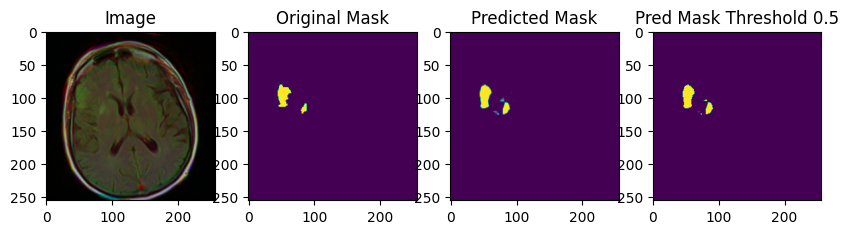

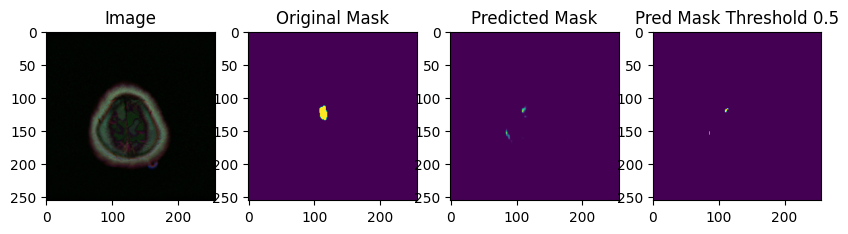

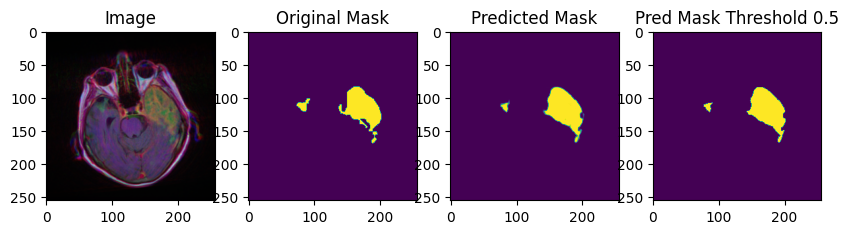

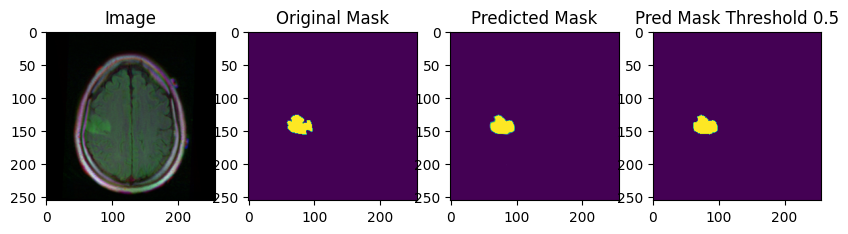

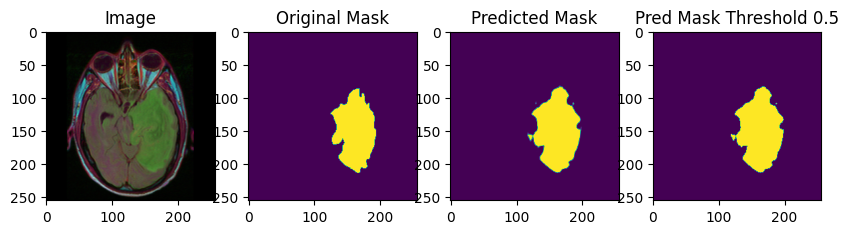

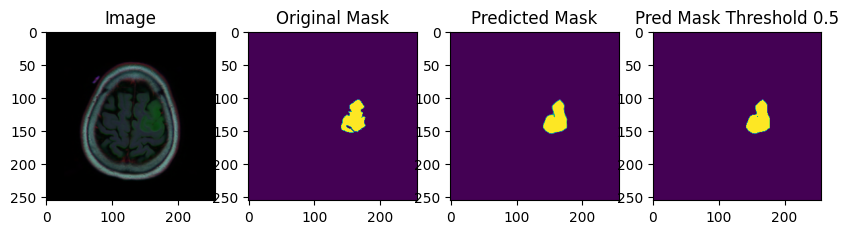

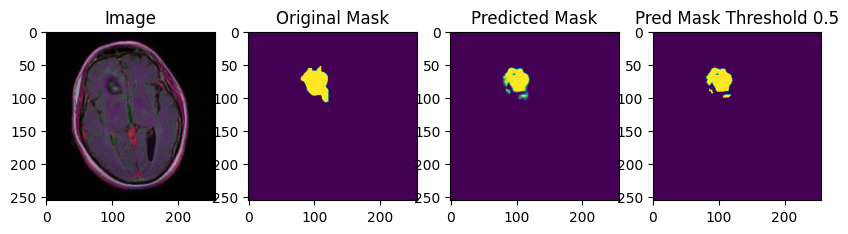

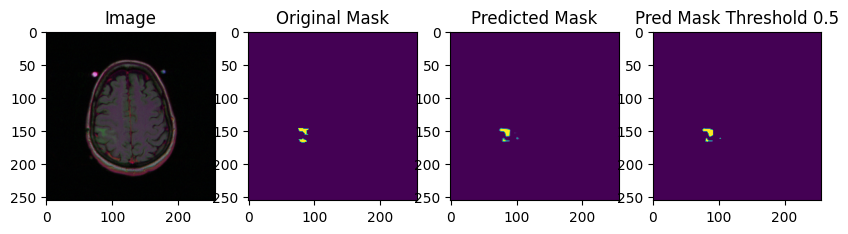

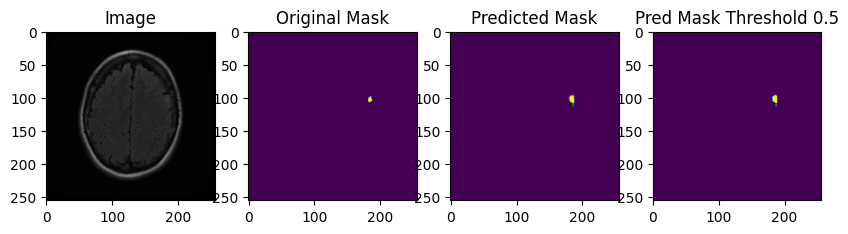

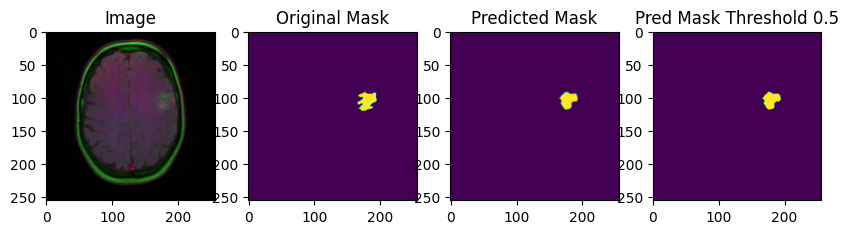

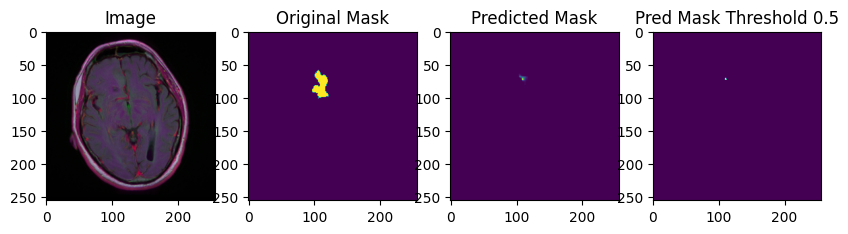

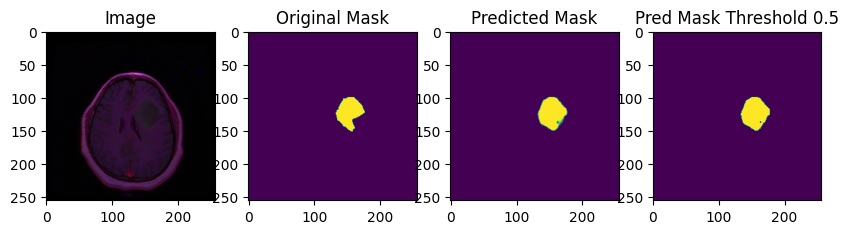

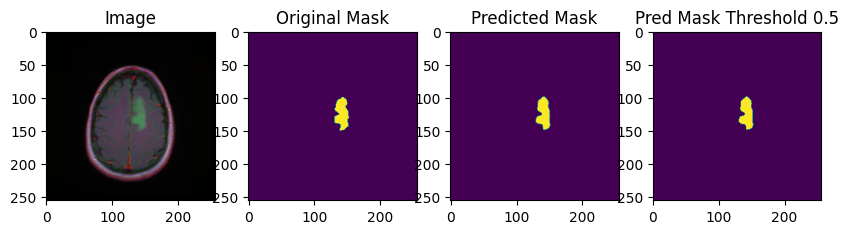

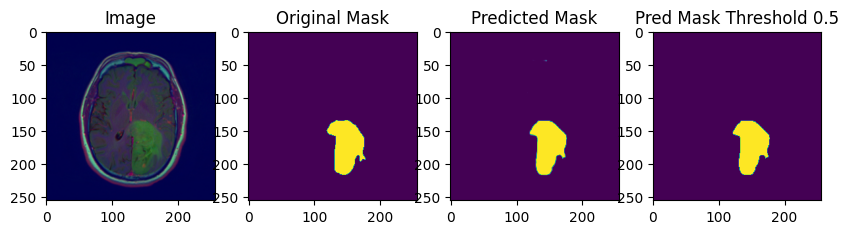

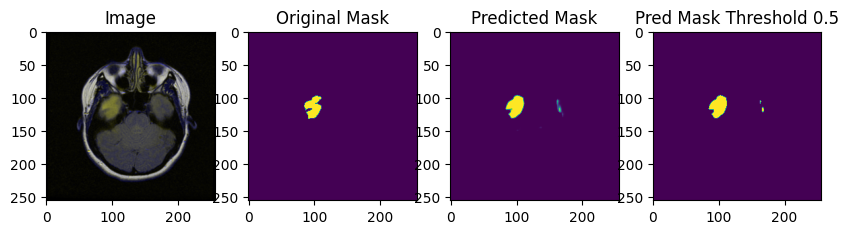

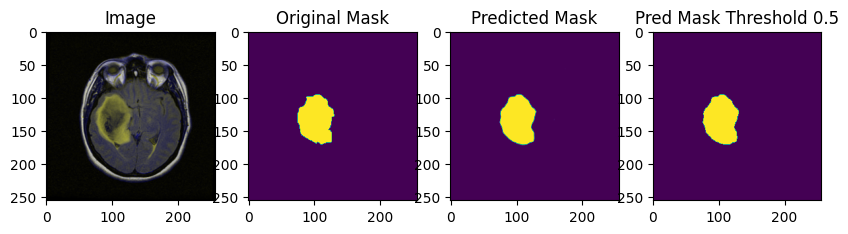

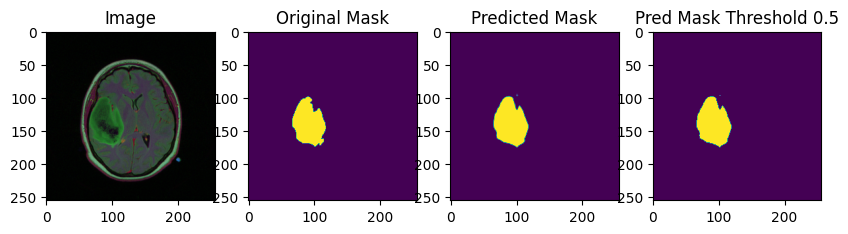

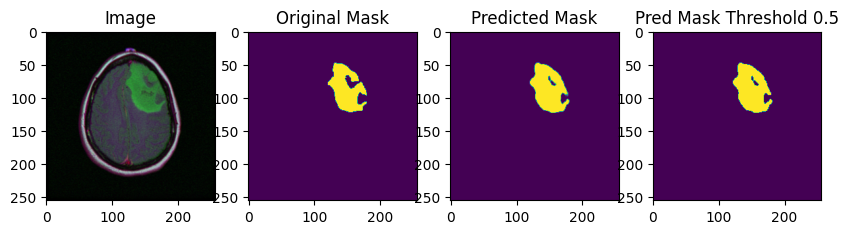

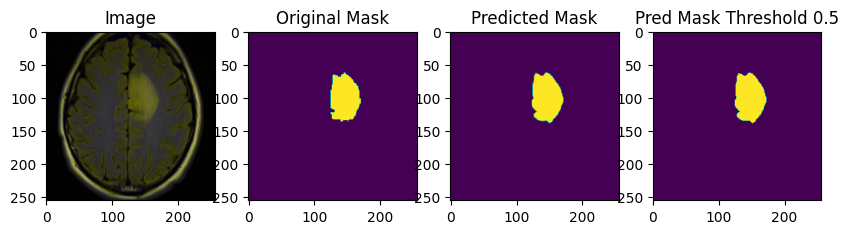

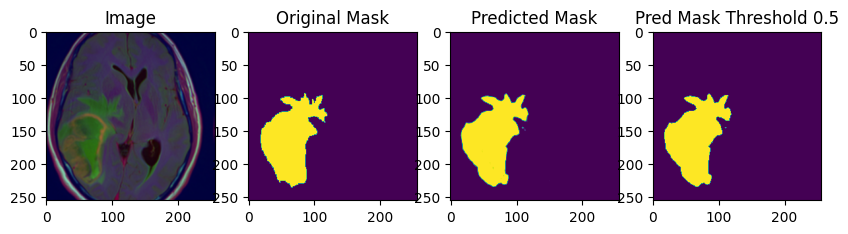

In [ ]:
random.seed(42)

# DeepLab
model.load_state_dict(torch.load('/content/drive/My Drive/PA026/savedModels/segmentation/DeepLabV3PLus5.pt'))
makeSamplePredictions(model, imagePaths, maskPaths, transformVal, 20, False)

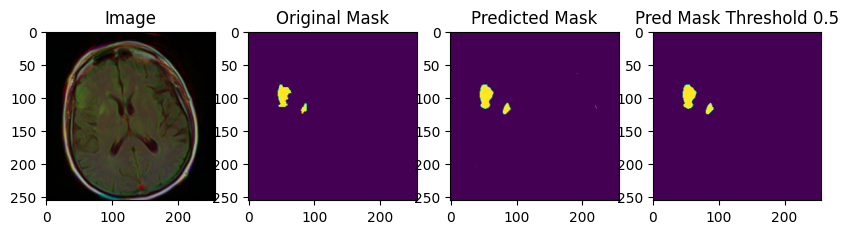

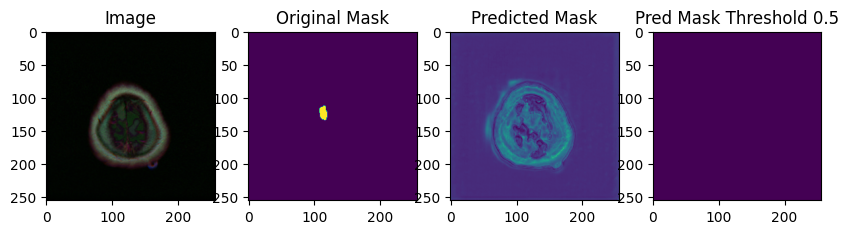

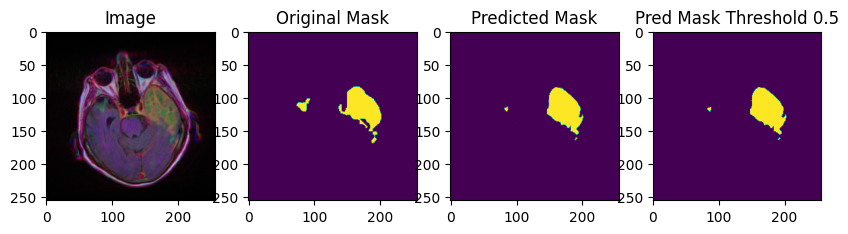

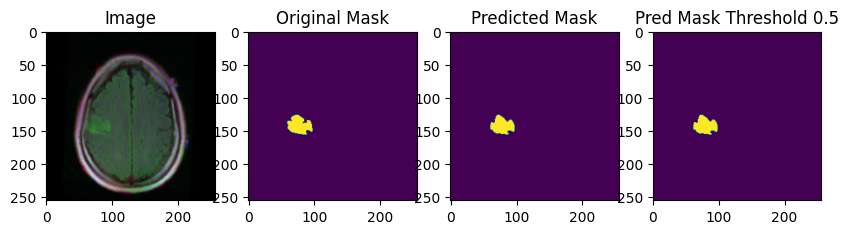

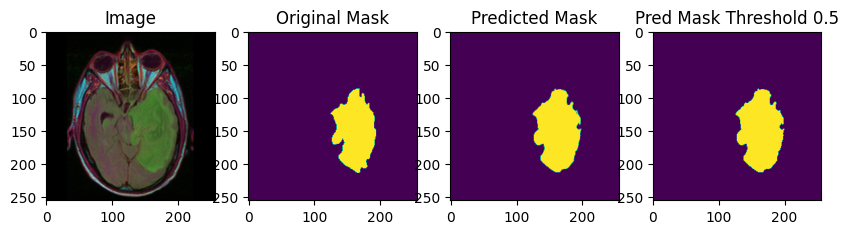

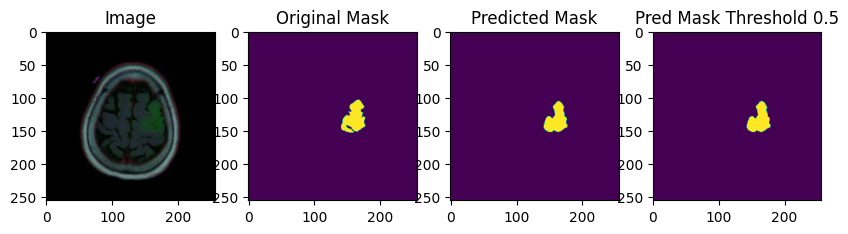

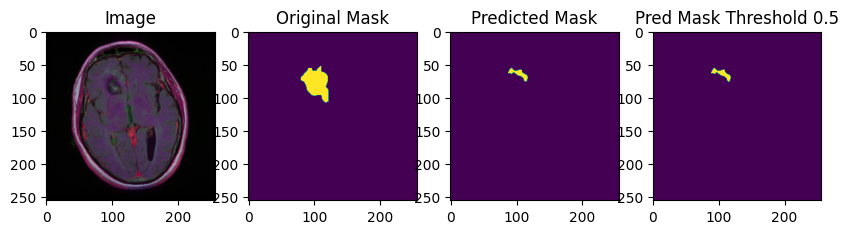

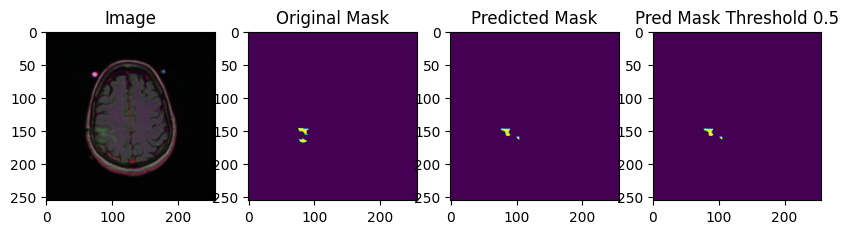

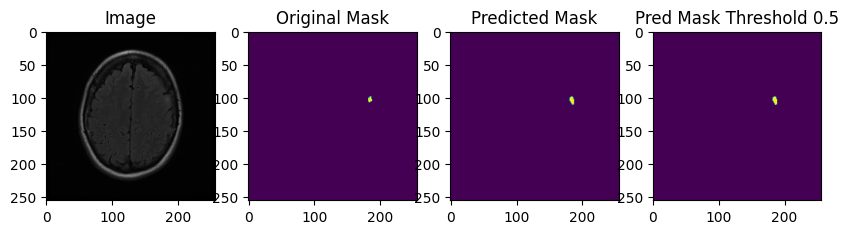

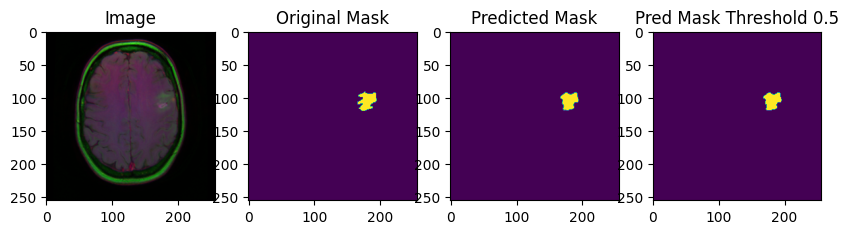

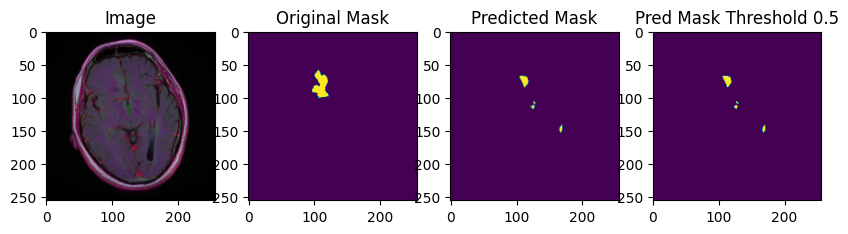

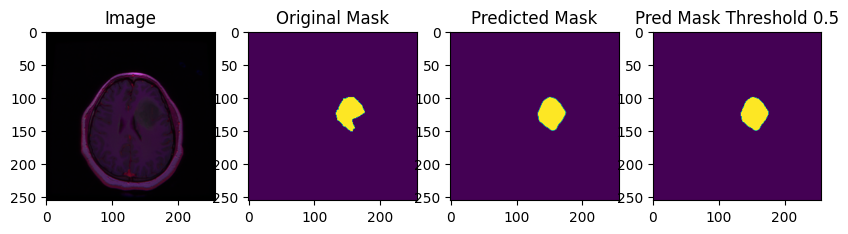

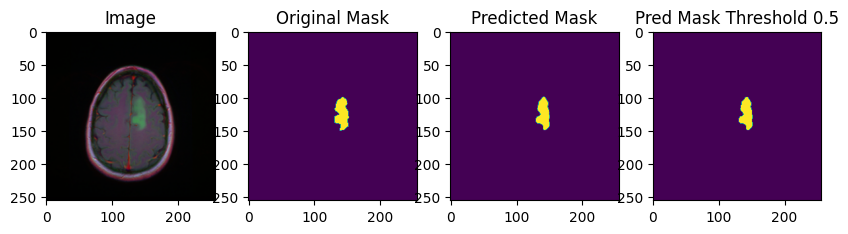

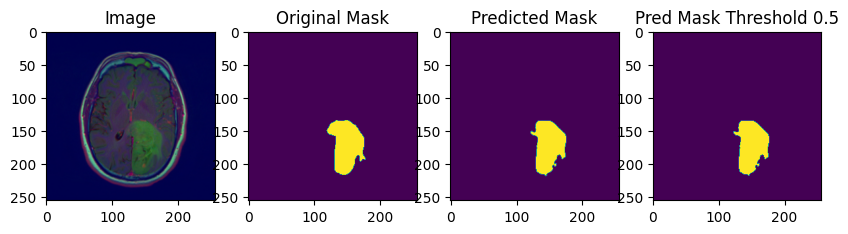

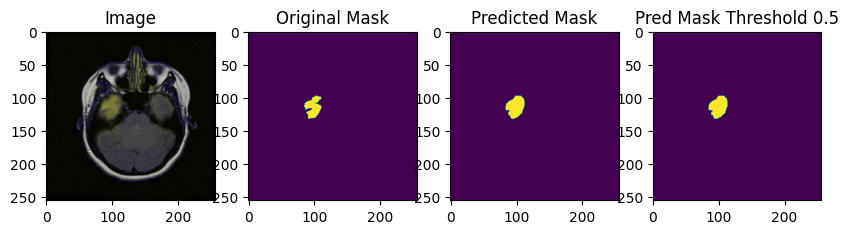

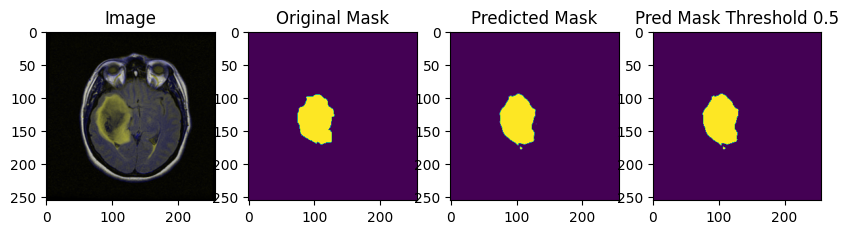

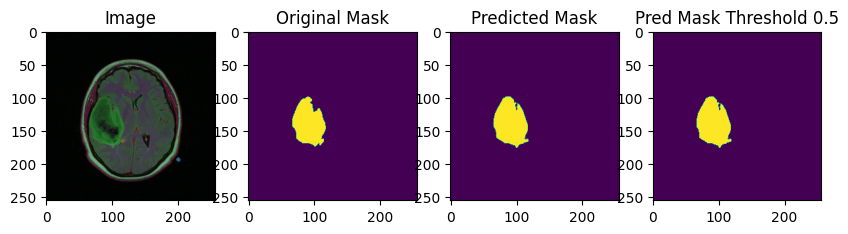

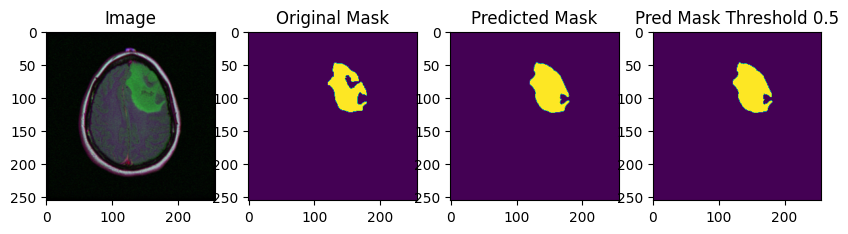

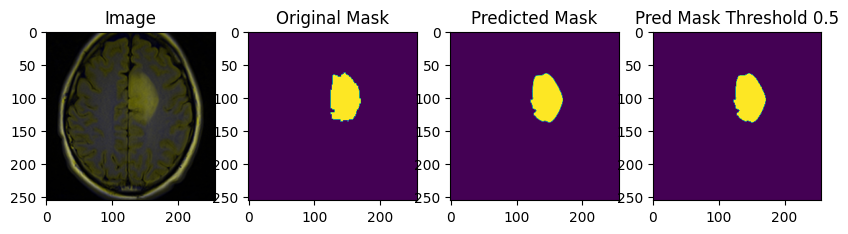

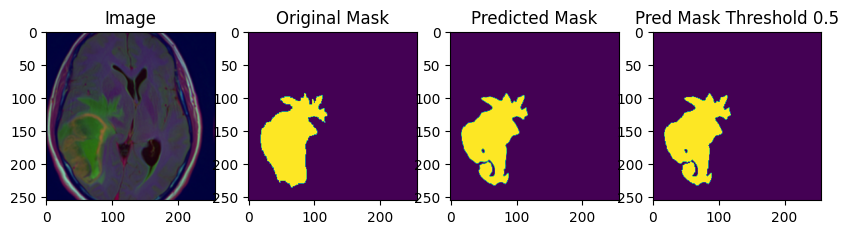

In [ ]:
random.seed(42)
model = getUnetModel().to(DEVICE)

model.load_state_dict(torch.load('/content/drive/My Drive/PA026/savedModels/segmentation/UNet5.pt'))
makeSamplePredictions(model, imagePaths, maskPaths, transformVal, 20, False)

# PA026 pipeline

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.python.keras import Sequential
from keras import layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *

from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

# GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

featureExResNet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))
featureExInception = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))
featureExIncResNet = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))

extractors = [featureExResNet, featureExInception, featureExIncResNet]
trainedModels = []
names = ['ResNet50Model_weights', 'InceptionV3Model_weights', 'InceptionResNetV2Model_weights']

unifiedTestingData = pd.read_csv(PROJECT_PATH+'data/testData.csv')

unifiedTestingData = unifiedTestingData.drop(columns=['Unnamed: 0'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
unifiedTestingData['label'] = unifiedTestingData['label'].apply(lambda x: str(x))
unifiedTestingData.info()

testDatagen = ImageDataGenerator(rescale=1./255.)

testGenerator = testDatagen.flow_from_dataframe(
        unifiedTestingData,
        directory='./',
        x_col='image',
        y_col='label',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
        target_size=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT)
    )

for i, ext in enumerate(extractors):
    model = tf.keras.Sequential(
        [   
            ext,
            layers.AveragePooling2D(pool_size=(4,4)),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(2, activation='softmax')
        ]
    )

    model.compile(loss = 'categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                metrics= ["accuracy"]
                )

    model.load_weights(PROJECT_PATH+'savedModels/classification/'+names[i]+'.hdf5')
    trainedModels.append(model)

preds = [m.predict(testGenerator) for m in trainedModels]
preds= np.array(preds)
weights = [0.3, 0.35, 0.35] # model weights

#use tensordot
weighted_pred = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_pred= np.argmax(weighted_pred, axis=1)

origLabels = np.asarray(unifiedTestingData['label']).astype('int')
weighted_acc = accuracy_score(origLabels, weighted_ensemble_pred)



print('\n')
print(classification_report(origLabels, weighted_ensemble_pred))

cf = confusion_matrix(origLabels, weighted_ensemble_pred)
acc_ensemble = (accuracy_score(origLabels, weighted_ensemble_pred) * 100)

print(cf)

219055592/219055592 [==============================] - 1s 0us/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   786 non-null    object
 1   mask    786 non-null    object
 2   label   786 non-null    object
dtypes: object(3)
memory usage: 18.5+ KB
Found 786 validated image filenames belonging to 2 classes.
27/27 [==============================] - 10s 214ms/step


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       511
           1       0.98      0.91      0.94       275

    accuracy                           0.96       786
   macro avg       0.96      0.95      0.96       786
weighted avg       0.96      0.96      0.96       786

[[505   6]
 [ 25 250]]
96.0559796437659


In [12]:
imPaths = []
mPaths = []

for i in range(len(unifiedTestingData)):
    if (weighted_ensemble_pred[i] == 1):
        imPaths.append(unifiedTestingData.loc[i, "image"])
        mPaths.append(unifiedTestingData.loc[i, "mask"])

classifiedAsTumor=pd.DataFrame()
classifiedAsTumor['image']= imPaths
classifiedAsTumor['mask']= mPaths

In [14]:
model = getDeepLabModel().to(DEVICE)
model.load_state_dict(torch.load(PROJECT_PATH+'savedModels/segmentation/DeepLabV3PLus5.pt'))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:04<00:00, 39.8MB/s]


<All keys matched successfully>

In [18]:
transformTest = augmentations.getTestAugmentations(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)
makeSamplePredictions(model, list(classifiedAsTumor['image']), list(classifiedAsTumor['mask']), transformTest, 50, False)

Output hidden; open in https://colab.research.google.com to view.